### Importing the csv files

In [2]:
import pandas as pd

sent = pd.read_csv("fear_greed_index.csv")
trades = pd.read_csv("historical_data.csv")

print("Sentiment dataset:")
print(sent.head())
print("\nTrades dataset:")
print(trades.head())


Sentiment dataset:
    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05

Trades dataset:
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.

#### Converting the timestamp column from epoch milliseconds → datetime.

In [3]:
sent['date']=pd.to_datetime(sent['date'])
trades['time']=pd.to_datetime(trades['Timestamp'],unit='ms')

sent['date_only']=sent['date'].dt.date
trades['date_only']=trades['time'].dt.date

In [6]:
print(sent['date_only'].head())
print(trades['date_only'].head())

0    2018-02-01
1    2018-02-02
2    2018-02-03
3    2018-02-04
4    2018-02-05
Name: date_only, dtype: object
0    2024-10-27
1    2024-10-27
2    2024-10-27
3    2024-10-27
4    2024-10-27
Name: date_only, dtype: object


#### Aggregate sentiment value

In [7]:
daily_sent=sent.groupby('date_only').agg({
    'value':'mean',
    'classification':lambda x: x.iloc[-1]}).reset_index().rename(columns={'value':'sent_value','classification':'sent_label'})

In [8]:
print(daily_sent.head())


    date_only  sent_value    sent_label
0  2018-02-01        30.0          Fear
1  2018-02-02        15.0  Extreme Fear
2  2018-02-03        40.0          Fear
3  2018-02-04        24.0  Extreme Fear
4  2018-02-05        11.0  Extreme Fear


#### Merging Trades with Sentiment

In [9]:
merged = trades.merge(daily_sent, on='date_only', how='left')
print(merged[['Account','Coin','Closed PnL','sent_label','sent_value']].head())


                                      Account  Coin  Closed PnL sent_label  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107         0.0      Greed   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107         0.0      Greed   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107         0.0      Greed   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107         0.0      Greed   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107         0.0      Greed   

   sent_value  
0        74.0  
1        74.0  
2        74.0  
3        74.0  
4        74.0  


#### Grouping tables by sentiment
It helps in showing Market sentiment affecting traders performance

In [14]:
grouped = merged.groupby('sent_label').agg(
    trades_count = ('Closed PnL','count'),
    mean_closedPnL=('Closed PnL','mean'),
    median_closedPnL=('Closed PnL','median'),
win_rate = ('Closed PnL', lambda x: (x>0).mean())
).reset_index()
print(grouped)

      sent_label  trades_count  mean_closedPnL  median_closedPnL  win_rate
0  Extreme Greed          6962       25.418772               0.0  0.490089
1           Fear        133871       50.047622               0.0  0.415146
2          Greed         36289       87.894859               0.0  0.446471
3        Neutral          7141       22.229713               0.0  0.317182


#### Visualization 

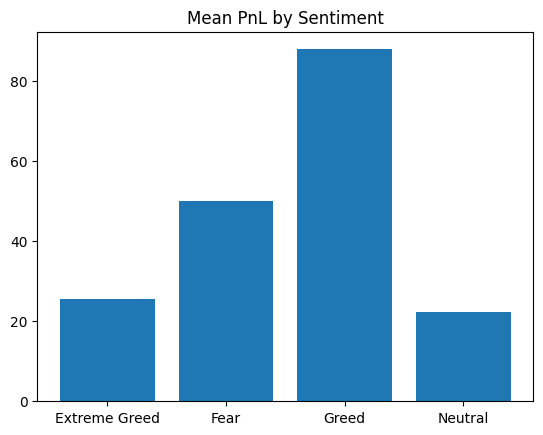

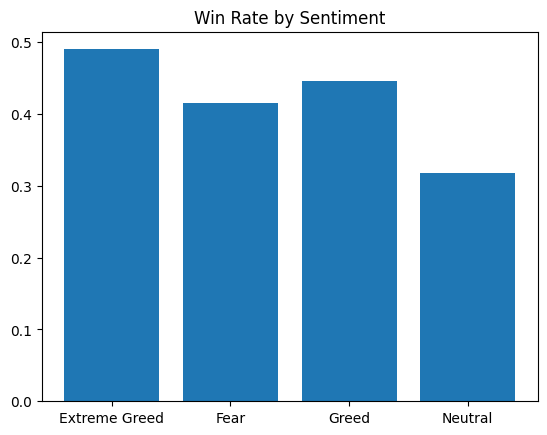

In [15]:
import matplotlib.pyplot as plt

plt.bar(grouped['sent_label'],grouped['mean_closedPnL'])
plt.title("Mean PnL by Sentiment")
plt.show()

plt.bar(grouped['sent_label'],grouped['win_rate'])
plt.title ("Win Rate by Sentiment")
plt.show()

#### business insight
-A trader might avoid Neutral sentiment days (worst performance).

-Greed sentiment offers the best reward, but with risk (lower win rate, higher variability).

-Extreme Greed is more balanced — good win rate, but not huge gains.

-Fear is where most activity happens → but perhaps irrational behavior dominates (high volume, middling results).

#### Normalizing Performance 
Why Normalize?A few huge trades can inflate the average.

Traders using big leverage or size look more profitable than smaller ones.
 Normalization makes performance comparable across all trades

In [19]:
import numpy as np

# Normalize PnL by trade size in USD
merged['PnL_per_usd'] = merged['Closed PnL'] / merged['Size USD'].replace(0, np.nan)

# Group again by sentiment
norm_grouped = merged.groupby('sent_label').agg(
    mean_PnL_per_usd=('PnL_per_usd', 'mean'),
    median_PnL_per_usd=('PnL_per_usd', 'median')
).reset_index()

print(norm_grouped)


      sent_label  mean_PnL_per_usd  median_PnL_per_usd
0  Extreme Greed          0.013736                 0.0
1           Fear          0.011358                 0.0
2          Greed          0.061848                 0.0
3        Neutral          0.015259                 0.0


####
Even after adjusting for trade size, Greed sentiment delivers the strongest returns (≈6% per $1 traded).
Fear, Extreme Greed, and Neutral yield much weaker returns (<2%).
This suggests that trading strategies should increase exposure during Greed sentiment and avoid Neutral sentiment, where profitability is lowest.

##### Split By Trade(Long vs short)

In [26]:
side_grouped = merged.groupby(['sent_label','Side']).agg(
    trades_count=('Closed PnL','count'),
    mean_closedPnL=('Closed PnL','mean'),
    mean_PnL_per_usd=('PnL_per_usd','mean'),
    win_rate=('Closed PnL',lambda x: (x > 0).mean())
).reset_index()

print(side_grouped)

      sent_label  Side  trades_count  mean_closedPnL  mean_PnL_per_usd  \
0  Extreme Greed   BUY          3371       25.578564          0.009612   
1  Extreme Greed  SELL          3591       25.268770          0.017606   
2           Fear   BUY         66081       58.074630          0.016944   
3           Fear  SELL         67790       42.222976          0.005912   
4          Greed   BUY         15421       12.489506          0.007880   
5          Greed  SELL         20868      143.617782          0.101752   
6        Neutral   BUY          3505       15.646108          0.001872   
7        Neutral  SELL          3636       28.576120          0.028231   

   win_rate  
0  0.456838  
1  0.521303  
2  0.261043  
3  0.565364  
4  0.220738  
5  0.613283  
6  0.390585  
7  0.246425  


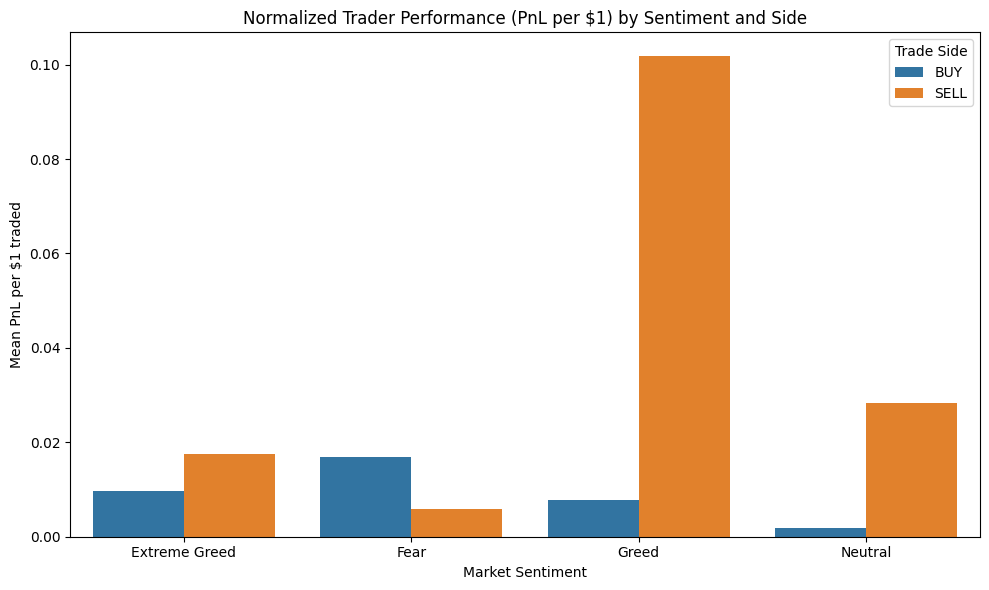

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(
    data=side_grouped,
    x='sent_label', 
    y='mean_PnL_per_usd', 
    hue='Side'
)

plt.title("Normalized Trader Performance (PnL per $1) by Sentiment and Side")
plt.xlabel("Market Sentiment")
plt.ylabel("Mean PnL per $1 traded")
plt.legend(title="Trade Side")
plt.tight_layout()
plt.show()


#### Insights
Greed sentiment: Short (SELL) trades are massively more profitable than longs, delivering the highest normalized PnL overall.

Fear sentiment: Long (BUY) trades outperform shorts in normalized PnL, but are less consistent (check win rate).

Extreme Greed: Both sides profitable, but shorts edge out slightly.

Neutral: Both sides weak → trading here is inefficient.

#### Time-Series Visualization
covers 1.Daily average trader PnL_per_usd

2.Overlay market sentiment score

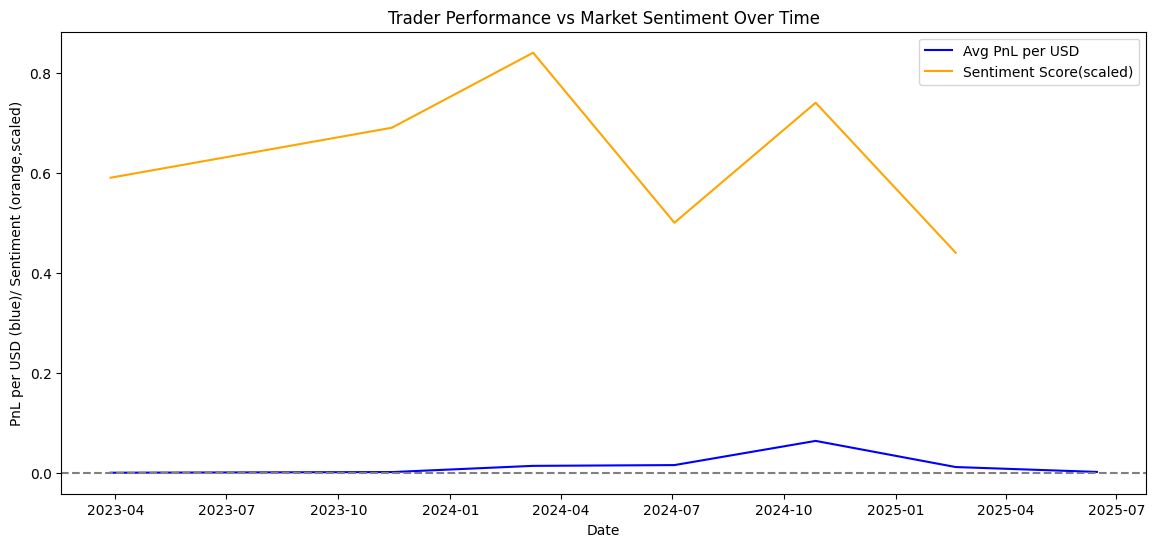

In [34]:
import matplotlib.pyplot as plt

daily_pnl = merged.groupby('date_only')['PnL_per_usd'].mean()

daily_sent = merged.groupby('date_only')['sent_value'].mean()

plt.figure(figsize=(14,6))
plt.plot(daily_pnl.index,daily_pnl,label='Avg PnL per USD',color='blue')
plt.plot(daily_sent.index,daily_sent/100,label='Sentiment Score(scaled)',color='orange')
plt.axhline(0,color='gray',linestyle='--')

plt.title ("Trader Performance vs Market Sentiment Over Time")
plt.xlabel("Date")
plt.ylabel("PnL per USD (blue)/ Sentiment (orange,scaled)")
plt.legend()
plt.show()

####
When sentiment spikes (Greed) → PnL also tends to go up.

During dips (Neutral/Fear) → PnL weakens or stays flat.

#### Strategy Recommendation Table

In [35]:
import pandas as pd
strategy_table = pd.DataFrame({
    'Sentiment':['Extreme Greed','Greed','Fear','Neutral'],
    'Best Side':['SELL > BUY','SELL','BUY','None'],
    'Avg Profitablity ':['Moderate','High','Moderate','Low'],
    'Win Rate Trend':['~52%','~61%','~41%','~32%'],
    'Suggested Action':[
        'Prefer shorts,caution longs',
        'Short aggressively',
        'Go Long cautiously',
        'Avoid trading']
})
print(strategy_table)
                               

       Sentiment   Best Side Avg Profitablity  Win Rate Trend  \
0  Extreme Greed  SELL > BUY          Moderate           ~52%   
1          Greed        SELL              High           ~61%   
2           Fear         BUY          Moderate           ~41%   
3        Neutral        None               Low           ~32%   

              Suggested Action  
0  Prefer shorts,caution longs  
1           Short aggressively  
2           Go Long cautiously  
3                Avoid trading  
